# import

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from copy import deepcopy
import string
from datetime import datetime
from PIL import Image, ImageDraw, ImageFont
import string

# functions



## plotting



In [0]:
# виводить зображення в заданому colorspace
def plot_image(image, colorspace='gray'):
  if colorspace:
    plt.imshow(image, colorspace) 
  plt.show()

  
# coordinates [words, 4] - координати bbox
# image [w, h] - зображення тексту
# write - чи зберігати зображення з bbox
# file_path - шлях де зберігати зображення з bbox
# малює квадрати що відповідають координатам bbox на image
def plot_bboxes(cordinates, image, file_path=None, dir_path=None):
  for (x,y,w,h) in cordinates:
      #bound the images
      cv2.rectangle(image, (x,y), (x+w,y+h), (0,255,0), 1)
  if file_path:
    cv2.imwrite(file_path, image)
  elif dir_path:
    file_path = os.path.join(dir_path, str(datetime.now()) + '.jpg')
    cv2.imwrite(file_path, image)
    

## new words finder (svyatoslav)

In [0]:
def get_words(img):
    """
    Function returns bboxes for each word and for chars in it.
    
    Parameters
    ----------
    img: np.array
    Thresholded grayscale image.
    
    Returns
    -------
    words: list
    Array of words bboxes in the form (x, y, w, h) where (x, y) - lower left point, h - height of bbox, w - width
    
    chars: list of lists
    Array which contains arrays that represent coordinates of each  character in word
    """
    
    # here we take maximum elements by word so we can detect rows with words
    # if there is a word the value would be 255, if not - 0
    maxs = np.max(img, axis=1) # maximum element by row
    indxs_y = np.where(maxs[:-1] != maxs[1:])[0] # indexes of elements where is transition from 255 to 0 or vice versa
    words = [] # list for storing words bboxes
    chars = [] # list for storing characters bboxes

    # In this loop we do the same operation but get max values by column so we can know
    # Where the character ends and starts
    for indx_y in range(0, len(indxs_y)-1, 2):

        distances = [] # list to store distances between 
        cordinates = []
        row = img[indxs_y[indx_y]:indxs_y[indx_y+1]] # take row of the text
        maxs1 = np.max(row, axis=0)
        indxs_x = np.where(maxs1[:-1] != maxs1[1:])[0]
        last_x = indxs_x[0]
        for indx_x in range(0, len(indxs_x)-1, 2):
            cordinates.append((
                indxs_x[indx_x],
                indxs_y[indx_y],
                indxs_x[indx_x+1] - indxs_x[indx_x],
                indxs_y[indx_y+1] - indxs_y[indx_y]
            ))
            distances.append(indxs_x[indx_x] - last_x)
            last_x = indxs_x[indx_x+1]

        temp = get_words_cordinates(cordinates, distances)
        if temp == -1:
            continue
        
        temp_words = temp[0]
        temp_chars = temp[1]
            
        words += temp_words
        chars += temp_chars
        
    return words, chars


def get_words_cordinates(cordinates, distances):
    """
    Parameters
    ----------
    cordinates: tuple or list which contains bboxes for each character in form - (x, y, w, h), where (x, y) - lower left point, h -       height of bbox, w - width
    
    """
    hist, bins = np.histogram(distances) # get histogram of distances between characters
    
    divider = find_divider(hist, bins) # get value by which we will decide if character belong to current word or starts next
    words = []
    chars = []
    x, y, w, h = cordinates[0]
    
    if w*h < 25: # weeding out anomalies
        return -1
    
    if check_for_one_word_in_line(distances): # check is it only one word in row so we can treat this case different
        for i, (x_t, y_t, w_t, h_t) in enumerate(cordinates[1:]):
            y = min(y, y_t)
            h = max(h, h_t)
            w += w_t + distances[i]
        
        words.append((x, y, w+distances[i+1], h))
        chars = cordinates
    else:
        start = 0 # start index for current word
        end = 0 # end index for current word
        for i, item in enumerate(distances[1:]):
            if item < divider:
                x_t, y_t, w_t, h_t = cordinates[i+1]
                y = min(y, y_t)
                w += w_t + item
                h = max(h, h_t)
                end += 1
            else:
                words.append((x, y, w, h))
                x, y, w, h = cordinates[i+1]
                end += 1
                chars.append(cordinates[start:end])
                start = end

        chars.append(cordinates[start:])
        words.append((x, y, w, h))
        
    return words, chars

def find_divider(hist, bins):
    """
    Function finds distance value.
    
    If distance between separate characters more than this value, characters are in the same word and if distance lower -                 characters belong to different words
    """
    left = 0
    right = len(hist)-1
    
    while hist[left] == 0:
        left += 1
        
    while hist[right] == 0:
        right -= 1
    
    divider = bins[left]*0.5 + bins[right]*0.5
    
    return divider
        
def check_for_one_word_in_line(distances):
    """
    Function chechs whether it is only one word in line
    """
    mean = np.mean(distances)
    var = np.var(distances)
    
    if mean > var:
        return True

    return False       


## word bbox coords



In [0]:
# gray_image [h,w] - grayscale зображеня
# dilation_iters - кількість ітерацій dilation (2, no resize - для тільки слів; 3, resize x 3 - для слів, а тоді 0 для літер з них)
# cordinates [objects, 4] - масив координатів bbox чорних об'єктів на зображенні 
def get_coords(gray_image, dilation_iters=2):
  #gray_image = cv2.ximgproc.l0Smooth(gray_image, 0.02, 2)
  ret, thresh1 = cv2.threshold(gray_image,240,255,cv2.THRESH_BINARY_INV)
  kernel = np.ones((2,1),np.uint8)
  thresh1 = cv2.dilate(thresh1, kernel, iterations=dilation_iters)
  _, contours, hierarchy = cv2.findContours(thresh1,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
  coordinates = []
  for cnt in contours:
      x,y,w,h = cv2.boundingRect(cnt)     # (x,y) - left down corner (plt), upper(cv2)
      if h > 11: # threshold
        coordinates.append((x,y,w,h))
  return np.asarray(coordinates)    


# img [rows, cols] - зображення тексту
# cordinates [words_num, 4] - (x,y,w,h) координати bbox
# метод святослава, різні шрифти - різні параметри
'''
roboto_mono_14: 1 dilate, 2,9-ones kernel
'''
'''
def get_words(img):
    maxs = np.max(img, axis=1) # Take 
    indxs_y = np.where(maxs[:-1] != maxs[1:])[0]
    cordinates = [] # (x, y, w, h)
    for indx_y in range(0, len(indxs_y)-1, 2):
        row = img[indxs_y[indx_y]:indxs_y[indx_y+1]]
        kernel = np.ones((2, 9), np.uint8)
        dilated = cv2.dilate(row, kernel, iterations=1)
        maxs1 = np.max(dilated, axis=0)
        indxs_x = np.where(maxs1[:-1] != maxs1[1:])[0]
        for indx_x in range(0, len(indxs_x)-1, 2):
            if indxs_x[indx_x+1] - indxs_x[indx_x] <= 3:
                continue
            cordinates.append((
                indxs_x[indx_x],
                indxs_y[indx_y],
                indxs_x[indx_x+1] - indxs_x[indx_x],
                indxs_y[indx_y+1] - indxs_y[indx_y]
            ))
            
    return cordinates
'''
  
# бере частини із зображення згідно координатам bbox
def get_images_by_coords(coords, image):
  images = []
  for (x,y,w,h) in coords:
    images.append(image[y:y+h, x:x+w])
  return images


# бере частини із зображення згідно координатам bbox
def get_images_by_coords_and_preprocess(coords, image):
  images = []
  for (x,y,w,h) in coords:
    word_image = deepcopy(image[y:y+h, x:x+w])
    word_image = pad_image(word_image)
    word_image = cv2.bilateralFilter(word_image,9,100,100) #diameter,
    images.append(word_image)
  return images



## getting word images by coords





In [0]:
# image_address - адреса зображення
# words_images - зображення слів із одного зображення тексту 
def get_words_images_and_cords(image_address, save_words_bboxes=0, save_dir_path=None):
  image = cv2.imread(image_address, 0)
  ret, thresh = cv2.threshold(image,180,255,cv2.THRESH_BINARY_INV)
  #w,h = image.shape[1], image.shape[0]
  #image = cv2.resize(image, (w*2, h*2), interpolation = cv2.INTER_CUBIC)
  word_coords, _ = get_words(thresh)
  if save_words_bboxes:
    plot_bboxes(word_coords, deepcopy(image), dir_path=save_dir_path)
  word_images = get_images_by_coords_and_preprocess(word_coords, image)                            # !!! PREPROCESS
  return word_images, word_coords, image
  

# images_dir_path - адреса директорії зі зображеннями
# all_words_images [images, word_images] - зображення всіх слів із кожного зображення тексту 
def get_all_words_images_and_coords(images_dir_path, write=0, save_dir_path=None):
  all_words_images = []
  all_words_coords = []
  all_text_images = []
  for address in sort_int_filenames(os.listdir(images_dir_path)):                                                     
    if address.split('.')[-1] == 'jpg' or 'JPG':
      word_images, word_coords, text_image = get_words_images_and_cords(os.path.join(images_dir_path, address), write, save_dir_path, return_coords)
      all_words_images.append(word_images)
      all_words_coords.append(word_coords)
      all_text_images(text_image)
  return all_words_images, all_words_coords, all_text_images


# filenames - масив назв файлів: ['2.jpg', '1.jpg']
# sorted_filenames - посортований масив назв файлів: ['1.jpg', '2.jpg']
def sort_int_filenames(filenames):
  names = [int(name.split('.')[0]) for name in filenames]
  sorted_names = sorted(names)
  sorted_filenames = [str(name)+'.JPG' for name in sorted_names]
  return sorted_filenames
  



## getting word names as labels



In [0]:
      
# labels_file_address - txt файл зі словами та номерами всіх зображеннь
#   слова кожного зображення розділені номером зображення 
#   (довжина лінії з номером < 5), всіх інших > 5
# all_images_words - [images, words] - слова з кожного зображення
def get_labels_words(labels_file_address):
  with open(labels_file_address) as f1:
    word_lines = f1.readlines()
  image_num=0
  image_words=[]
  all_images_words=[]
  for line in word_lines[1:]: # 0 - номер першого зображення
    ln = len(line)
    if ln>10: # номер сампла
      #line = line.replace('.','')
      line_words = line.split(' ')[0:-1] # \n
      image_words += line_words
    else:
      all_images_words.append(image_words)
      image_words=[]
      image_num+=1
  image_num+=1
  all_images_words.append(image_words) # last hasn't sample_num after
  return all_images_words # == all_names
  
  
# all_images_words [images, words] - слова з кожного зображення
# alphabet_str - стрічка з алфавітом 'lower,upper,digits'
# words_indexes [images, indexes] - зображення та їх слова через індекси символів
def get_labels_indexes(all_image_words, alphabet_str):
  all_image_indexes = []
  for i in range(len(all_image_words)):
    image_words_indexes=[]
    for word in all_image_words[i]:
      word_indexes =  indexes_from_word(word, alphabet_str)
      image_words_indexes.append(word_indexes)
    all_image_indexes.append(image_words_indexes)
  return all_image_indexes
# ||  ||  ||
# word - стрічка
# alphabet_str - str алфавіт символів
# indexes - str, заміна символів у слові на їх індекси в алфавіті
def indexes_from_word(word, alphabet_str):
  indexes = []
  for char in word:
    indexes.append(alphabet_str.find(char))
  return '_'.join(map(str, indexes))



## saving images with label-names



In [0]:

# word_images - [samples, h, w, 1] - зображення
# image_names - [samples, str] - назви зображеннь, індекси символів зі слів на них [a-z, A-z, 0-9] - [0-61] indexes
def save_word_images(word_images, image_names, save_path):
  for word_image, image_name in zip(word_images, image_names):
    full_save_path = os.path.join(save_path, image_name) + '.jpg'
    cv2.imwrite(full_save_path, word_image)


# all_words_images [images, words, h ,w] - зображення слів із кожного зображення тексту
# all_worlds_images_names [images, names] - імена слів із кожного зображення тексту
# save_dir_path - шлях до директорії для збереження слів
def save_all_words_images(all_words_images, all_words_images_names, save_dir_path):
  for words_images, images_names, i in zip(all_words_images, all_words_images_names, range(len(all_words_images))):
    save_dir_path1 = os.path.join(save_dir_path, str(i))
    if not os.path.exists(save_dir_path1):
      os.mkdir(save_dir_path1)
    save_word_images(words_images, images_names, save_dir_path1)
 
    




## resize and pad



In [0]:
# images_dict - {назва_зображення: зображення} 
# ratio - множник ширини та висоти зображення  (для new_h=False)
# new_h - якщо задане тоді кожне зображення збільшується до його висоти
# resized_images_dict - {назва_зображення: ресайзнуте_зображення}
def resize_images(images_dict, ratio=1, new_h=False):
  if not new_h:
    interpolation =  get_interpolation(ratio) # для всіх однаково
  resized_images_dict = {}
  for name, img in images_dict.items():
    h, w = img.shape
    ratio = new_h/h
    if new_h:
      interpolation =  get_interpolation(ratio) # у залежності від h
    image = cv2.resize(img, (int(w*ratio), int(h*ratio)), interpolation=interpolation)
    resized_images_dict[name]=image
  return resized_images_dict
  
  
# ratio - множник ширини та висоти зображення
# interpolation - тип зміни зображення
def get_interpolation(ratio):
  if ratio<1:
      interpolation = cv2.INTER_AREA # краще для зменшення
  else:
    interpolation = cv2.INTER_CUBIC # краще для збільшення
  return interpolation


# image [h, w] - зображення
#
# pad_image [32, 128] - змінене зображення 
def pad_image(image):
  h, w = image.shape
  print(h,w)
  pad_h = 32-h
  pad_w = 128-w
  pad_image = np.pad(image, ((pad_h, 0), (0,pad_w)), 'constant', constant_values=(255))
  return pad_image
  

# all_words_images [images, word_images, h1, w1] - зображення всіх слів із кожного зображення тексту
# h1,w1 < 32,128
#
# padded_images [images, word_images, 32, 128] - зображення з паддінгом (право і верх) 
def pad_all_images(all_words_images):
  all_padded_images = []
  for text_image in all_words_images:
    padded_word_images = []
    for word_image in text_image:
      padded_word_images.append(pad_image(word_image))
    all_padded_images.append(padded_word_images)
  return all_padded_images
    
    

## txt to image

### font paths

In [0]:
# add calibri later
font_paths = {
    'roboto_mono': r'/content/drive/My Drive/Colab Notebooks/course_project/data_crnn/fonts/roboto-mono/RobotoMono-Regular.ttf',
    'arial': r'/content/drive/My Drive/Colab Notebooks/course_project/data_crnn/fonts/Arial/ArialRegular/ArialRegular.ttf',
    'armino': r'/content/drive/My Drive/Colab Notebooks/course_project/data_crnn/fonts/arimo/Arimo-Regular.ttf',
    'helvetica': r'/content/drive/My Drive/Colab Notebooks/course_project/data_crnn/fonts/helvetica/HelveticaRegular/HelveticaRegular.ttf',
    'open_sans': r'/content/drive/My Drive/Colab Notebooks/course_project/data_crnn/fonts/open-sans/OpenSans-Regular.ttf',
    'roboto2014': r'/content/drive/My Drive/Colab Notebooks/course_project/data_crnn/fonts/roboto-2014/Roboto-Regular.ttf',
    'times_new_roman': r'/content/drive/My Drive/Colab Notebooks/course_project/data_crnn/fonts/times-new-roman/times-new-roman.ttf',
    'calibri': r'/content/drive/My Drive/Colab Notebooks/course_project/data_crnn/fonts/calibri font sv/Calibri Regular/Calibri Regular.ttf',
    'courier': r'/content/drive/My Drive/Colab Notebooks/course_project/data_crnn/fonts/COURIER/COURIER.TTF',
    'lato': r'/content/drive/My Drive/Colab Notebooks/course_project/data_crnn/fonts/Lato2OFL/Lato2OFL/Lato-Regular.ttf',
    'shadows_into_light': r'/content/drive/My Drive/Colab Notebooks/course_project/data_crnn/fonts/Shadows-into-light_Typeface_1813_(Fontmirror)/Shadows Into Light 400.ttf',
    'abel': r'/content/drive/My Drive/Colab Notebooks/course_project/data_crnn/fonts/abel/abel-regular.ttf',
    'abril_fatface': r'/content/drive/My Drive/Colab Notebooks/course_project/data_crnn/fonts/abril-fatface/AbrilFatface-Regular.otf',
    'acme': r'/content/drive/My Drive/Colab Notebooks/course_project/data_crnn/fonts/acme/Acme-Regular.ttf',
    'amatic': r'/content/drive/My Drive/Colab Notebooks/course_project/data_crnn/fonts/amatic/Amatic-Bold.ttf',
    'anton': r'/content/drive/My Drive/Colab Notebooks/course_project/data_crnn/fonts/anton/Anton.ttf',
    'archivo': r'/content/drive/My Drive/Colab Notebooks/course_project/data_crnn/fonts/archivo/Archivo-Regular.ttf',
    'arimo': r'/content/drive/My Drive/Colab Notebooks/course_project/data_crnn/fonts/arimo/Arimo-Regular.ttf',
    'asap': r'/content/drive/My Drive/Colab Notebooks/course_project/data_crnn/fonts/asap_regular/asap.regular.ttf',
    'assistant': r'/content/drive/My Drive/Colab Notebooks/course_project/data_crnn/fonts/assistant/Assistant-Regular.otf',
    'barlow': r'/content/drive/My Drive/Colab Notebooks/course_project/data_crnn/fonts/barlow_regular/barlow.regular.ttf',
    'bitter': r'/content/drive/My Drive/Colab Notebooks/course_project/data_crnn/fonts/bitter/Bitter-Regular.ttf',
    'bree_serif': r'/content/drive/My Drive/Colab Notebooks/course_project/data_crnn/fonts/bree_serif/bree-serif.regular.ttf',
    'cabin': r'/content/drive/My Drive/Colab Notebooks/course_project/data_crnn/fonts/cabin/cabin.regular.ttf',
    'cairo': r'/content/drive/My Drive/Colab Notebooks/course_project/data_crnn/fonts/cairo/Cairo Medium.ttf',
    'catamaran': r'/content/drive/My Drive/Colab Notebooks/course_project/data_crnn/fonts/catamaran/Catamaran-Regular.ttf',
    'caveat': r'/content/drive/My Drive/Colab Notebooks/course_project/data_crnn/fonts/caveat/caveat-regular.ttf',
    'comfortaa': r'/content/drive/My Drive/Colab Notebooks/course_project/data_crnn/fonts/comfortaa/Comfortaa-Regular.ttf',
    'comic_sans': r'/content/drive/My Drive/Colab Notebooks/course_project/data_crnn/fonts/comic-sans-ms/COMIC.TTF',
    'crimson_text': r'/content/drive/My Drive/Colab Notebooks/course_project/data_crnn/fonts/crimson-text/CrimsonText-Roman.ttf',
    'dancing': r'/content/drive/My Drive/Colab Notebooks/course_project/data_crnn/fonts/dancing/dancing-script.regular.ttf',
    'dosis': r'/content/drive/My Drive/Colab Notebooks/course_project/data_crnn/fonts/dosis/dosis.book.ttf',
    'exo': r'/content/drive/My Drive/Colab Notebooks/course_project/data_crnn/fonts/exo/Exo-Regular.ttf',
    'firasans': r'/content/drive/My Drive/Colab Notebooks/course_project/data_crnn/fonts/firasans/FiraSans-Regular.otf',
    'fjalla_one': r'/content/drive/My Drive/Colab Notebooks/course_project/data_crnn/fonts/fjalla-one/FjallaOne-Regular.ttf',
    'garamond': r'/content/drive/My Drive/Colab Notebooks/course_project/data_crnn/fonts/garamond/Garamond.ttf',
    'georgia': r'/content/drive/My Drive/Colab Notebooks/course_project/data_crnn/fonts/georgia-2-cufonfonts/georgia.ttf',
    'hind': r'/content/drive/My Drive/Colab Notebooks/course_project/data_crnn/fonts/hind/Hind-Regular.ttf',
    'impact': r'/content/drive/My Drive/Colab Notebooks/course_project/data_crnn/fonts/impact/impact.ttf',
    'inconsolata': r'/content/drive/My Drive/Colab Notebooks/course_project/data_crnn/fonts/inconsolata/Inconsolata-Regular.ttf',
    'indie_flower': r'/content/drive/My Drive/Colab Notebooks/course_project/data_crnn/fonts/indie_flower_16818/IndieFlower.ttf',
    'josefin_sans': r'/content/drive/My Drive/Colab Notebooks/course_project/data_crnn/fonts/josefin-sans/JosefinSans-Regular.ttf',
    'kanit': r'/content/drive/My Drive/Colab Notebooks/course_project/data_crnn/fonts/kanit/Kanit-Regular.ttf',
    'karla': r'/content/drive/My Drive/Colab Notebooks/course_project/data_crnn/fonts/karla/Karla-Regular.ttf',
    'lobster': r'/content/drive/My Drive/Colab Notebooks/course_project/data_crnn/fonts/lobster/The-Lobster-Font/fonts/TTF/Lobster.ttf',
    'open_sans': r'/content/drive/My Drive/Colab Notebooks/course_project/data_crnn/fonts/open-sans/OpenSans-Regular.ttf',
    'oswald': r'/content/drive/My Drive/Colab Notebooks/course_project/data_crnn/fonts/oswald/Oswald-Regular.ttf',
    'pacifico': r'/content/drive/My Drive/Colab Notebooks/course_project/data_crnn/fonts/pacifico/Pacifico.ttf',
    'quicksand': r'/content/drive/My Drive/Colab Notebooks/course_project/data_crnn/fonts/quicksand/Quicksand-Regular.ttf',
    'raleway': r'/content/drive/My Drive/Colab Notebooks/course_project/data_crnn/fonts/raleway/Raleway-Regular.ttf',
    'righteous': r'/content/drive/My Drive/Colab Notebooks/course_project/data_crnn/fonts/righteous/Righteous-Regular.ttf',
    'roboto': r'/content/drive/My Drive/Colab Notebooks/course_project/data_crnn/fonts/roboto/Roboto-Regular.ttf',
    'ubuntu': r'/content/drive/My Drive/Colab Notebooks/course_project/data_crnn/fonts/ubuntu/ubuntu-font-family-0.80/Ubuntu-R.ttf',
    'yanone': r'/content/drive/My Drive/Colab Notebooks/course_project/data_crnn/fonts/yanone-kaffeesatz/YanoneKaffeesatz-Regular.ttf'
    
}

### train set create

In [0]:
# font_names [fonts_n] - масив назв шрифтів
# imgs_range [2] - індекси початкового та кіневого-1 зображення 
# alphabet_str - стрічка з алфавітом
# labels_path - шлях до y.txt
# save_dir_path - шлях до директорії для зображеннь
def save_train_set(font_names, imgs_range, alphabet_str, labels_path, save_dir_path):
  all_labels_words = get_labels_words(labels_path)
  all_labels_indexes = get_labels_indexes(all_labels_words, alphabet_str) #[img_n, word_n]
  if imgs_range == 0:
    imgs_range = [0, len(all_labels_indexes)] # всі зображення
  
  img = Image.new('RGB', (128, 32), color = (255, 255, 255))                                      #!!! better, but how copy ?
  for f in font_names:
    font = ImageFont.truetype(font_paths[f], 14)
    font_dir_path = os.path.join(save_dir_path, f)
    if not os.path.exists(font_dir_path):
      os.mkdir(font_dir_path)
    
    for i in range(*imgs_range):
      img_dir_name = '0' * (5 - len(str(i))) + str(i)
      img_dir_path = os.path.join(font_dir_path, img_dir_name)
      if not os.path.exists(img_dir_path):
        os.mkdir(img_dir_path)
      
      for w in range(len(all_labels_indexes[i])):     
        temp_word = all_labels_words[i][w]
        temp_img = (img.copy())
        d = ImageDraw.Draw(temp_img)
        d.text((2, 12), temp_word, font=font, fill=(0, 0, 0))
        open_cv_image = np.array(temp_img)
        open_cv_image = deepcopy(open_cv_image[:, :, ::-1]) # RGB to BGR
        open_cv_image = cv2.bilateralFilter(open_cv_image,9,100,100) #diameter, 
        
        full_save_path = os.path.join(img_dir_path, all_labels_indexes[i][w]+'.jpg')
        cv2.imwrite(full_save_path, open_cv_image)


# font_names [fonts_n] - масив назв шрифтів
# imgs_range [2] - індекси початкового та кіневого-1 зображення 
# alphabet_str - стрічка з алфавітом
# labels_path - шлях до y.txt
# save_dir_path - шлях до директорії для зображеннь
def save_train_set_from_image(imgs_dir_path, imgs_range, alphabet_str, labels_path, save_dir_path):
  all_words_images, coords = get_all_words_images_and_coords(images_dir_path, write=0, save_dir_path=None)
  all_words_images = pad_all_images(all_words_images)
  all_labels_words = get_labels_words(labels_path)
  all_labels_indexes = get_labels_indexes(all_labels_words, alphabet_str) #[img_n, word_n]
  if imgs_range == 0:
    imgs_range = [0, len(all_labels_indexes)] # всі зображення
    
  for i in range(*imgs_range):
    img_dir_name = '0' * (5 - len(str(i))) + str(i)
    img_dir_path = os.path.join(save_dir_path, img_dir_name)
    if not os.path.exists(img_dir_path):
      os.mkdir(img_dir_path)
      
    for w in range(len(all_labels_indexes[i])):     
      temp_word_img = all_words_images[i][w]
      temp_word_img = cv2.bilateralFilter(temp_word_img,9,100,100) #diameter, 
      
      full_save_path = os.path.join(img_dir_path, all_labels_indexes[i][w]+'.jpg')
      cv2.imwrite(full_save_path, temp_word_img)

In [0]:
tmp_path = r'/content/drive/My Drive/Colab Notebooks/course_project/data_crnn/train/x'
font_names = []
for path_name in font_paths.keys():
  if not path_name in os.listdir(tmp_path):
      font_names.append(path_name)

print(font_names)
print(len(font_names))

In [0]:
tmp_path = r'/content/drive/My Drive/Colab Notebooks/course_project/data_crnn/train/x'
font_names = []
for font_name in os.listdir(tmp_path):
  if not len(os.listdir(os.path.join(tmp_path,path))):
    font_names.append(font_name)
print(font_names)

[]




> **save train from autogen words**



In [0]:
%%time

save_dir_path = r'/content/drive/My Drive/Colab Notebooks/course_project/data_crnn/test/x_new'
labels_path = r'/content/drive/My Drive/Colab Notebooks/course_project/data/test/y_test/y_test.txt' # old test labels
labels_path2 = r'/content/drive/My Drive/Colab Notebooks/course_project/data_crnn/test/y_new/roboto_mono_20_new3.txt' # new labels
alphabet_str = string.ascii_letters + string.digits + '.'

font_names = ['roboto_mono']#font_names
imgs_range = 0

save_train_set(font_names, imgs_range, alphabet_str, labels_path2, save_dir_path)


CPU times: user 4.36 s, sys: 281 ms, total: 4.64 s
Wall time: 20.5 s





> **save train set from image**





In [0]:
save_dir_path = r'/content/drive/My Drive/Colab Notebooks/course_project/data_crnn/test_on_text/x'
labels_path = r'/content/drive/My Drive/Colab Notebooks/course_project/data/test/y_test/y_test.txt'
alphabet_str = string.ascii_letters+string.digits + '.'
imgs_range = 0
imgs_dir_path = r'/content/drive/My Drive/Colab Notebooks/course_project/data/test/x_test'


save_train_set_from_image(imgs_dir_path, imgs_range, alphabet_str, labels_path, save_dir_path)

In [0]:
# set_generating max time = (font_num * image_num * 2sec)/60sec
(39 * 40 * 2)/60 # ~ minutes for 39fonts x 40imgs; (~ 1img / 2s)  
(5 * 10 * 2)/60
  

1.6666666666666667

## get batches

In [0]:

# data_dir_path - шлях до директорії із трейн сетом (шрифтами)
# font_names [fonts_n] - масив назв шрифтів
# curent_batch_size - кількість випадкових слів
# font_p [len(font_names)] - ймовірності для кожного шрифту попасти в датасет
#
# rand_word_paths [batch_size] - випадкові адреси зображеннь слів
def get_random_word_paths(data_dir_path, font_names, current_batch_size, font_p=None):
  rand_font_name = np.random.choice(font_names, p=font_p) # 1 font choice
  font_dir_path = os.path.join(data_dir_path, rand_font_name)
  
  rand_img_name = np.random.choice(os.listdir(font_dir_path)) # 1 img choice
  img_dir_path = os.path.join(font_dir_path, rand_img_name)
  
  word_names = os.listdir(img_dir_path)
  batch_chunk = len(word_names) - current_batch_size # batch_words 
  if batch_chunk >= 0: # вистачає слів для батча в цьому зображенні
    rand_words = np.random.choice(word_names, current_batch_size)
    rand_word_paths = [os.path.join(img_dir_path, w_n) for w_n in rand_words]
  else: # для батча треба більше слів ніж є в даному зображенні
    rand_words = np.random.choice(word_names, len(word_names))
    rand_word_paths = [os.path.join(img_dir_path, w_n) for w_n in rand_words]
    rand_word_paths += get_random_word_paths(data_dir_path, font_names, abs(batch_chunk), font_p) # добираю слова до batch_size    
    
  return rand_word_paths


# data_dir_path - шлях до директорії із трейн сетом (шрифтами)
# font_names [fonts_n] - масив назв шрифтів
# batch_size - кількість зобраеннь слів
# max_word_len - максимальна довжина слова
# font_p [len(font_names)] - ймовірності для кожного шрифту попасти в датасет
# 
# batch_x [batch_size, 34, 128] - зображення слів
# batch_y [batch_size, max_word_len] - індекси літер для слів + нулі(якщо word_len<max_word_len)
# word_lens [batch_size] - довжини слів
def get_batch(data_dir_path, font_names, batch_size, max_word_len, font_p=None):
  batch_x = np.zeros((batch_size, 32, 128))
  batch_y = np.zeros((batch_size, max_word_len))
  word_lens = np.zeros((batch_size,)) 
  rand_words_adress = get_random_word_paths(data_dir_path, font_names, batch_size, font_p) # batch випадкових адес слів
            
  for i, word_path in enumerate(rand_words_adress):
    batch_x[i] = minmax_image(cv2.imread(word_path, 0))
    word_name = word_path.split('/')[-1][:-4] # без .jpg
    char_indexes = list(map(int, word_name.split('_')))
                  
    if len(char_indexes) > max_word_len: # обрізаю задовге слово
      char_indexes = char_indexes[:max_word_len]
    ch_len = len(char_indexes) 
    word_lens[i] = ch_len
    batch_y[i][:ch_len] = char_indexes
    #batch_x = standartize_images(batch_x)
  return batch_x, batch_y, word_lens

# image [h, w] - зображення
# mm_image [h,w] - мін-макс нормалізоване зображення
def minmax_image(image):
  mm_image = image-image.min() + 0.001
  mm_image = mm_image/mm_image.max() - 0.0001
  return mm_image


# images [batch, h, w] - зображення
# st_images [batch, h, w] - стандартизовані по батчу зображення
def standartize_images(images):
  st_images = (images - np.mean(images))
  st_images /= (np.std(st_images))
  return st_images

In [0]:
%%time
data_dir_path = r'/content/drive/My Drive/Colab Notebooks/course_project/data_crnn/train/x'
font_names = ['roboto_mono', 'helvetica', 'comic_sans', 'arial', 'times_new_roman']
batch_size = 10
max_word_len = 16
font_p = [0.3, 0.2, 0.1, 0.2, 0.2] 

#rnd_w_pths = get_random_word_paths(data_dir_path, font_names, batch_size, font_p)
batch_x, batch_y, word_lens = get_batch(data_dir_path, font_names, batch_size, max_word_len, font_p)


In [0]:
# len([pth for pth in rnd_w_pths if 'roboto_mono' in pth])    # font words num

print(len(batch_x), batch_x[1], sep='\n')
print('',len(batch_y), batch_y[1], sep='\n')
print('\n',word_lens[1])


## random char batches

In [0]:
# # batch_size - кількість зображеннь слів
# font_name - наза шрифта
# max_word_len - максимальна довжина слова 
# alphabet_arr - масив з алфавітом
# font_paths - словник {назва шрифа: адрес шрифта}
# downsample_factor - наскільки пулінги зменшують зображення вширину
def data_gen_rand(batch_size, font_name, max_word_len, alphabet_arr, font_paths, downsample_factor=4):
  while 1:
    batch_x = np.zeros((batch_size, 128, 32))
    batch_y = np.zeros((batch_size, max_word_len))
    word_lens = np.zeros((batch_size, 1)) 
    input_lens = np.ones((batch_size, 1)) * (128 // downsample_factor - 2)
    
    img = Image.new('L', (128, 32), color = 255)
    font = ImageFont.truetype(font_paths[font_name], 14)
    
    for i in range(batch_size):
      rand_len = np.random.choice(max_word_len-1)+1
      word =  ''.join(np.random.choice(alphabet_arr, rand_len))
      word_indexes = indexes_from_word(word, ''.join(alphabet_arr))
      
      batch_y[i, :rand_len] = (word_indexes)
      word_lens[i, 0] = rand_len
      
      temp_img = (img.copy())
      d = ImageDraw.Draw(temp_img)
      d.text((2, 12), word, font=font, fill=0)
      open_cv_image = np.array(temp_img).T
      open_cv_image = cv2.bilateralFilter(open_cv_image,9,100,100) #diameter, 
      batch_x[i] = minmax_image(open_cv_image)
    batch_x = np.reshape(batch_x, [-1,128,32,1])
    inputs = {
      'the_input': batch_x, 
      'the_labels': batch_y,
      'input_length': input_lens,
      'label_length': word_lens
    }
    outputs = {'ctc': np.zeros([batch_size])} # не юзається бо лосс функція не юзає output, а юзає лейбли з інпута 
    yield inputs, outputs
     
      
# word - стрічка
# alphabet_str - str алфавіт символів
# indexes - arr, заміна символів у слові на їх індекси в алфавіті      
def indexes_from_word(word, alphabet_str):
  indexes = []
  for char in word:
    indexes.append(alphabet_str.find(char))
  return indexes


# image [h, w] - зображення
# mm_image [h,w] - мін-макс нормалізоване зображення
def minmax_image(image):
  mm_image = image-image.min() + 0.001
  mm_image = mm_image/mm_image.max() - 0.0001
  return mm_image


# letters [class_num] - alphabet array
# chars - decoded chars
def get_chars_from_indexes(indexes, alphabet_str):
  chars = ''.join([alphabet_str[int(i)] for i in indexes])
  return chars

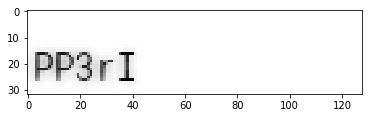

[41. 41. 55. 17. 34.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
PP3rIaaaaaaaaaaa


In [0]:
data_gen_kwargs = {
   'batch_size' : 1,
  'font_name' : 'roboto_mono',
  'max_word_len' : 16,
  'alphabet_arr': list(string.ascii_letters + string.digits + '.'),
  'font_paths': font_paths
}

for i, data in enumerate(data_gen_rand(**data_gen_kwargs)):
  inputs, outputs = data
  plot_image(np.reshape(inputs['the_input'][0], [128,32]).T)
  indexes = inputs['the_labels'][0]
  alphabet_str = ''.join(data_gen_kwargs['alphabet_arr'])
  print(indexes)
  print(get_chars_from_indexes(indexes, alphabet_str))
  if i == 0:
    break
    
    

## get images and coords for full predict

In [0]:
import itertools


# y_pred [32, num_classes] - Розподіл ймовірностей для 32 ділянок фото
# highest_prob_chars [word_len] - передбачене слово
def decode_label(y_pred, alphabet_str):
    # out : (1, 32, 64)
    highest_prob_classes = list(np.argmax(y_pred[2:], axis=1)) # індекс класу з макс ймовірністю
    highest_prob_classes = [k for k, g in itertools.groupby(highest_prob_classes)]  # забирає суміжні повторні значення
    highest_prob_chars = get_chars_from_indexes(highest_prob_classes, alphabet_str) # видаляє пропуски, декодує індекси
    return highest_prob_chars

  
# letters [class_num] - alphabet array
# chars - decoded chars str
def get_chars_from_indexes(indexes, alphabet_str):
  chars = ''.join([alphabet_str[int(i)] for i in indexes if i<len(alphabet_str)])
  return chars


# y_pred [batch, 32, num_classes] - батч розподілів ймовірностей 
# alphabet_str [num_classes] - алфавіт, символи всіх класів (lower+upper+digits+.)
#
# pred_words [batch_size, ?] - батч передбачених слів
def get_words_arr_from_y(y_pred, alphabet_str):
  pred_words = []
  for i in range(len(y_pred)):
    pred_word = decode_label(y_pred[i], alphabet_str)
    pred_words.append(pred_word)
  return pred_words


# image [32, 128] - зображення тексту
# words [words_num] - масив передбачених слів
# words_coords [words_num] - масив передбачених координат
def highlight_most_frequent(image, words, words_coords):
  highlighted_img = deepcopy(image)
  counter = Counter(words)
  if not counter.most_common(1):
    return
  most_frequent_word = counter.most_common(1)[0][0]
  for i, word in enumerate(words):
    if word == most_frequent_word:
      (x, y, w, h) = words_coords[i]
      temp_area = deepcopy(highlighted_img[y:y+h, x:x+w])
      ret, thresh = cv2.threshold(img,127,255,cv2.THRESH_BINARY_INV)
      mask = deepcopy(thresh[y:y+h, x:x+w])
      temp_area[mask == 255] = [255, 0, 0]
      highlighted_img[y:y+h, x:x+w] = temp_area 
  
  return highlighted_img


# font_names [fonts_n] - масив назв шрифтів
# imgs_range [2] - індекси початкового та кіневого-1 зображення 
# alphabet_str - стрічка з алфавітом
# labels_path - шлях до y.txt
# save_dir_path - шлях до директорії для зображеннь
def save_highlights_from_images(model, images_dir_path, labels_path, batch_size, alphabet_str, save_dir_path):
  all_words_images, all_words_coords, all_text_images = get_all_words_images_and_coords(images_dir_path, write=0, save_dir_path=None)
  all_words_images = pad_all_images(all_words_images)
  
  all_labels_words = get_labels_words(labels_path)
  all_labels_indexes = get_labels_indexes(all_labels_words, alphabet_str) #[img_n, word_n]
  
  for i in range(len(all_words_images)):
    img_pred_words = []
    offset = 0
    word_num = len(all_words_images[i])
    
    while offset < word_num:
      if offset+batch_size > word_num:
        batch_x = all_words_images[i, offset:]
      else:
        batch_x = all_words_images[i, offset:batch_size]
        offset+=batch_size
      y_pred = model.predict_on_batch(batch_x)
      
      img_pred_words += get_words_arr_from_y(y_pred, alphabet_str)
    
    highlighted_image = highlight_most_frequent(all_text_images[i], img_pred_str, all_words_coords[i]) 
    cv2.imwrite(os.join(save_dir_path, str(i)+'.jpg'), highlighted_image)
      

# main



> **test**



In [0]:
image_address = r'/content/drive/My Drive/Colab Notebooks/course_project/data/test/x_test/1.JPG'
labels_file_address = r'/content/drive/My Drive/Colab Notebooks/course_project/data/test/y_test/y_test.txt'
alphabet_str = string.ascii_letters + string.digits + '.'

all_labels_words = get_labels_words(labels_file_address)
all_labels_indexes = get_labels_indexes(all_labels_words, alphabet_str)



In [0]:
images_dir_path = r'/content/drive/My Drive/Colab Notebooks/course_project/data/test/x_test'
bbox_save_path = r'/content/drive/My Drive/Colab Notebooks/course_project/data_crnn/images'

all_words_images, coords = get_all_words_images_and_coords(images_dir_path, 1, bbox_save_path)



In [0]:
save_dir_path = r'/content/drive/My Drive/Colab Notebooks/course_project/data_crnn/test/x'

#save_all_words_images(all_words_images, all_labels_indexes, save_dir_path)

In [0]:
# видаляє збережені get_all_words_images_and_coords() зображення з виділеними ббоксами слів 
for file_name in os.listdir(bbox_save_path):
  os.remove(os.path.join(bbox_save_path,file_name))

In [0]:
img_n = [0,5]
wrd_n = [0,1]
for i in range(*img_n):
  for j in range(*wrd_n):
    temp = cv2.bilateralFilter(all_words_images[i][j],9,100,100) #diameter 
    plot_image(all_words_images[i][j])
    plot_image(temp)
    print('label: {}'.format(all_labels_words[i][j]))
    print('index: {}'.format(all_labels_indexes[i][j]))

In [0]:
# формат вхідних даних - після трешхолду чи ні ?